# Population Modelling

Model: a collection of elements designed in order to understand and simulate how complex systems works. Models which do not belong to the Big Data regime, are designed so that to gain insights of how certain variables affect an outcome

That all models are wrong, but some are useful
-- George Box

### Explaination

Applying different types of social distancing and limited movement restrictions, could potentially lead to a good cointainement of the spreading of a desease, but also to a major shrink of the whole economy. In the following simulation, two main types of responses are simulated: no containement at all or imposing an hard lockdown. In order to keep track of the economic consequences of these two different approaches, the created population has been divided into 3 different classes: Working Class, Middle Class and Upper Class. Which have assigned different types of incomes and expenses which they have to pay on daily bases depending on their income. The government offers the opportunity to give financial support on daily basis in case any of the citizen is struggling to pay its expenses. In a fully functioning society, most of the citizen are able to pay their expenses without having to use their savings or ask for help. As restrictions are imposed and freedom of movement is limited, citizen can only continue to earning and be self-sufficient if they are able to work from home. Otherwise, the will have to make use of their savings and of the government support provided. Because of the neture of their work, middle and higher class workers, are more likely be able to work remotely.

In normal conditions, the updated income of a citizen on daily basis is equal to:
- Updated Income = (Income - Expense)*abs(Current Position - Previous Position)

In this way, the ability of moving freely is represented as a way to possibly increase their income (eg. citizen can travel to work and during working activities).

If citizens can't pay their expenses, they can use their savings and if they run out of them they can ask finantial support. The financial support covers just the daily expenses and can be asked every day.

If a citizen dies, can't ask for finantial support or earn any money.

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [44]:
class Person:
    def __init__(self, situation, position, speed, extremes, age, soc_class):
        self.situation, self.position = situation, position
        self.speed, self.extremes = speed, extremes
        angle = np.random.uniform(0, 2*np.pi)
        self.x_dir, self.y_dir = np.cos(angle), np.sin(angle)
        self.age = age
        self.soc_class = soc_class
        self.savings = 0
        self.reabilitation = 0
        self.social_assistance = 0
        
    def step_ahead(self, community, proximity, contagiousness, no_move, deaths_p, top_remote_working, low_remote_working):
        self = contacts(self, community, proximity, contagiousness, deaths_p)
        self = new_pos(self, no_move, top_remote_working, low_remote_working)

def contacts(ind, community, proximity, unlikelyness_of_contact, p_died):
    if (ind.situation == 2) or (ind.situation == 3):
        pass
    elif ind.situation == 1:
        if np.random.choice(2, 1, p=[1-p_died*ind.age, p_died*ind.age])[0] == 0:
            ind.reabilitation += 1
            if ind.reabilitation >= 14:
                ind.situation = 2
        else:
            ind.situation = 3
    else:
        close_people = 0
        for friend in community:
            xx = (ind.position[0]-friend.position[0])
            yy = (ind.position[1]-friend.position[1])
            if (friend.situation == 1) and ((np.sqrt(xx**2 + yy**2) < proximity)):
                close_people += 1
        if sum([1 for x in np.random.random(close_people) if x >unlikelyness_of_contact]) > 0:
            ind.situation = 1
    return ind

def calc_income(ind, end, start, no_move, top_remote_working, low_remote_working):
    if ind.situation != 3:
        if ind.soc_class == 0:
            inc = random.randint(30, 40)
            out = random.randint(0, 15)
        elif ind.soc_class == 1:
            inc = random.randint(80, 140)
            out = random.randint(20, 70)
        elif ind.soc_class == 2:
            inc = random.randint(200, 500)
            out = random.randint(50, 180)
        if (((end-start)==0) or ((inc-out)<=0)):
            #print(ind.savings, out)
            if ((ind.savings-out) >= 0):
                ind.social_assistance = 0
                daily_earning =  -out
            else:
                # Governmant Lockdown Support
                ind.social_assistance = 1 #social_assistance
                daily_earning =  0
            
            if (no_move==True) and (ind.soc_class != 0):
                if np.random.choice(2, 1, p=[1-top_remote_working, top_remote_working])[0] == 1:
                    daily_earning = random.uniform(0, 1.5)*(inc-out)
                    ind.social_assistance = 0
                elif ((ind.savings-out) >= 0):
                    ind.social_assistance = 0
                    daily_earning =  -out
                else:
                    ind.social_assistance = 1 #social_assistance
                    daily_earning =  0
                    
                    
            if (no_move==True) and (ind.soc_class == 0):
                if np.random.choice(2, 1, p=[1-low_remote_working, low_remote_working])[0] == 1:
                    daily_earning = random.uniform(0, 1.5)*(inc-out)
                    ind.social_assistance = 0
                elif ((ind.savings-out) >= 0):
                    ind.social_assistance = 0
                    daily_earning =  -out
                else:
                    ind.social_assistance = 1 #social_assistance
                    daily_earning =  0
        else:
            daily_earning = abs(end-start)*(inc-out)
            ind.social_assistance = 0
    else:
        ind.social_assistance = 0
        daily_earning = 0 
        
    ind.savings += daily_earning


def check_bounds(ind, x_or_y, travelled_dist, i, no_move, top_remote_working, low_remote_working):
    if ind.position[i] + x_or_y*travelled_dist < ind.extremes[i][0]:
        updated_pos = -ind.position[i] + (-x_or_y*travelled_dist) + 2*ind.extremes[i][0]
        updated_dir = -x_or_y 
    elif ind.position[i] + ind.x_dir*travelled_dist > ind.extremes[i][1]:
        updated_pos = -ind.position[i] + (-x_or_y*travelled_dist) + 2*ind.extremes[i][1]
        updated_dir = -x_or_y
    else:
        updated_pos = ind.position[i] + x_or_y*travelled_dist
        if no_move:
            updated_dir = 0 
        else:    
            updated_dir = x_or_y
    calc_income(ind, updated_pos, ind.position[i], no_move, top_remote_working, low_remote_working)
    return updated_pos, updated_dir

def new_pos(ind, no_move, top_remote_working, low_remote_working):
    travelled_dist = ind.speed*np.random.random()
    ind.position[0], ind.x_dir = check_bounds(ind, ind.x_dir, travelled_dist, 0, no_move, 
                                              top_remote_working, low_remote_working)
    ind.position[1], ind.y_dir = check_bounds(ind, ind.y_dir, travelled_dist, 1, no_move, 
                                              top_remote_working, low_remote_working)
    return ind


def pop_simulation(size, iterations, probs_positives, 
                   grid_lists, min_contact_radious, 
                   unlikelyness_of_spread, static, d_p, avg_age, 
                   top_remote_working, low_remote_working):
    population = []
    for grid_l in grid_lists:
        for i in range(0, size//len(grid_lists)):
            population.append(Person(np.random.choice(2, 1, p=[1-probs_positives, probs_positives])[0], 
                                    [random.uniform(grid_l[0][0], grid_l[0][1]), 
                                     random.uniform(grid_l[1][0], grid_l[1][1])],
                                    random.uniform(0, 1), grid_l, 
                                    min(2, max(1, np.random.normal(1+avg_age, 0.12, 1)[0])),
                                    random.randint(0, 2)))


    negatives, positives, survivors = [], [], []
    x_res, y_res, state = [], [], []
    index, deaths = [], []
    savings, soc_class = [], []
    soc_help = []
    for it in range(iterations):
        it_negative, it_positives, it_survivors, it_dead = 0, 0, 0, 0
        poor_class, med_class, rich_class = 0, 0, 0
        poor_inc, med_income, rich_income = 0, 0, 0
        for i, single in enumerate(population):
            x_res.append(single.position[0])
            y_res.append(single.position[1])
            index.append(it)
            soc_class.append(single.soc_class)
            savings.append(single.savings)
            soc_help.append(single.social_assistance)
            if single.situation == 0:
                it_negative += 1
                state.append('Susceptible')
            elif single.situation == 1:
                it_positives += 1
                state.append('Infected')
            elif single.situation == 3:
                it_dead += 1
                state.append('Died')
            else:
                it_survivors += 1
                state.append('Recovered')
            single.step_ahead(population[:i]+population[i+1:], min_contact_radious, 
                              unlikelyness_of_spread, no_move=static, deaths_p=d_p, 
                              top_remote_working=top_remote_working, 
                              low_remote_working=low_remote_working)
        negatives.append(it_negative)
        positives.append(it_positives)
        survivors.append(it_survivors)
        deaths.append(it_dead)
        
    return negatives, positives, survivors, deaths, x_res, y_res, state, index, soc_class, savings, soc_help

Age between 1 and 2 multiplied with the death probability 1 +0.7 =1.7 (70 years alse)

1.4986947584285053


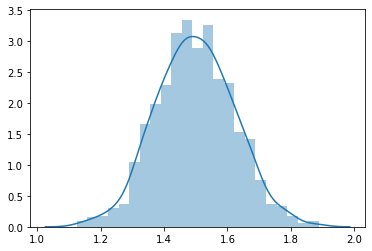

In [3]:
num = []
for i in range(1000):
    num.append(min(2, max(1, np.random.normal(1.5, 0.12, 1))))

print(np.mean(num))
import seaborn as sns
import matplotlib.pyplot as plt

AA1_plot  = sns.distplot(num, kde=True, rug=False)
plt.show()

6


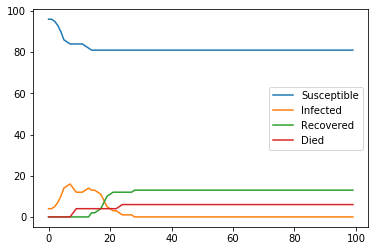

In [45]:
probs_positives = 0.04
# The first pair represents the bounding X coordinates, while the second pair represents the Y coordinates
grid_max = [[0, 5], [0, 5]]
grid_limits = [grid_max, [[0, 1], [0,1]], [[4, 5], [4, 5]], [[0, 1], [4, 5]], [[4, 5], [0, 1]]]
min_contact_radious = 0.3
unlikelyness_of_spread = 0.9
iterations = 100
size = 100
static = True
d_p = 0.02
avg_age = 0.9
top_remote_working, low_remote_working = 0.8, 0.35

negatives, positives, survivors, deaths, x_res, y_res, state, index, soc_class, savings, soc_help =pop_simulation(size, 
                                                                                     iterations, 
                                                                                     probs_positives, 
                                                                                     grid_limits, 
                                                                                     min_contact_radious, 
                                                                                     unlikelyness_of_spread, 
                                                                                     static, d_p, avg_age, 
                                                                                     top_remote_working, 
                                                                                     low_remote_working)

print(deaths[len(deaths)-1])
plt.plot(negatives, label='Susceptible')
plt.plot(positives, label='Infected')
plt.plot(survivors, label='Recovered')
plt.plot(deaths, label='Died')
plt.legend()
plt.show()

In [46]:
d = {'x_pos': x_res, 'y_pos': y_res, 'state': state, 'index':index}
df = pd.DataFrame(data=d)
#df.head()
for i in list(df['index'].unique()):
    for j in list(df['state'].unique()):
        if len(df[(df['index']==i) & (df['state'] == j)]) == 0:
            df = df.append(pd.DataFrame([[grid_max[0][1]+5, grid_max[1][1]+5, j, i]], 
                                        columns=df.columns))

In [47]:
d2 = {'Savings': savings, 'Social Class': soc_class, 'Social Help': soc_help, 'index':index}
df2 = pd.DataFrame(data=d2)
df2.head()

,Savings,Social Class,Social Help,index
0,0.0,1,0,0
1,0.0,1,0,0
2,0.0,1,0,0
3,0.0,2,0,0
4,0.0,0,0,0


In [48]:
daily_average_savings = []
daily_support_requests = []
for j in [0, 1, 2]:
    day_savings, day_help = [], []
    for i in list(df2['index'].unique()):
        day_savings.append(np.mean(df2[(df2['index']==i) & (df2['Social Class']==j)]['Savings'].values))
        day_help.append(np.sum(df2[(df2['index']==i) & (df2['Social Class']==j)]['Social Help'].values))
    daily_average_savings.append(day_savings)
    daily_support_requests.append(day_help)

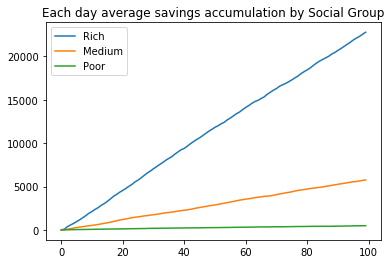

In [49]:
plt.plot(daily_average_savings[2], label='Rich')
plt.plot(daily_average_savings[1], label='Medium')
plt.plot(daily_average_savings[0], label='Poor')
plt.title("Each day average savings accumulation by Social Group")
plt.legend()
plt.show()

Total support requests from Rich people:  1
Total support requests from Medium people:  3
Total support requests from Poor people:  50


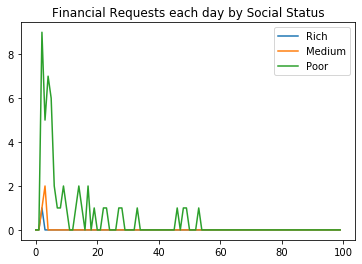

In [50]:
print("Total support requests from Rich people: ", sum(daily_support_requests[2]))
print("Total support requests from Medium people: ", sum(daily_support_requests[1]))
print("Total support requests from Poor people: ", sum(daily_support_requests[0]))
plt.plot(daily_support_requests[2], label='Rich')
plt.plot(daily_support_requests[1], label='Medium')
plt.plot(daily_support_requests[0], label='Poor')
plt.title("Financial Requests each day by Social Status")
plt.legend()
plt.show()

In [42]:
def replay_plot(negatives, positives, survivors, deaths, df, grid_max, daily_average_savings, daily_support_requests):
    fig = make_subplots(rows=3, cols=2, 
                       specs=[[{"colspan": 2}, None], [{"colspan": 2}, None], [{ }, { }]], horizontal_spacing = 0.2,
                       vertical_spacing = 0.2)

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
                         mode="lines",
                         line=dict(width=2, color="blue"), name='Susceptible',),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=positives,
                         mode="lines",
                         line=dict(width=2, color="green"), name='Infected',),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
                         mode="lines",
                         line=dict(width=2, color="orange"), name='Recovered',),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=deaths,
                         mode="lines",
                         line=dict(width=2, color="black"), name='Died',),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
        x=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Susceptible')]['x_pos'], 
        y=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Susceptible')]['y_pos'],
        name='Susceptible',
        mode='markers',
        marker=dict(
        color="blue"),
        showlegend=False
        ),
        row=2, col=1)

    fig.add_trace(go.Scatter(
        x=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Infected')]['x_pos'], 
        y=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Infected')]['y_pos'],
        name='Infected',
        mode='markers',
        marker=dict(
        color="green"),
        showlegend=False
        ),
        row=2, col=1)

    fig.add_trace(go.Scatter(
        x=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Recovered')]['x_pos'], 
        y=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Recovered')]['y_pos'],
        name='Recovered',
        mode='markers',
        marker=dict(
        color="orange"),
        showlegend=False
        ),
        row=2, col=1)
    
    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=daily_average_savings[0],
                                 mode="lines", name='Working Class',
                                 line=dict(width=2, color="red")),
        row=3, col=1)
    
    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=daily_average_savings[1],
                                 mode="lines", name='Middle class',
                                 line=dict(width=2, color="purple")),
        row=3, col=1)
    
    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=daily_average_savings[2],
                                 mode="lines", name='Upper class',
                                 line=dict(width=2, color="brown")),
        row=3, col=1)

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=daily_support_requests[0],
                                 mode="lines", name='Working Class',
                                 line=dict(width=2, color="red"),
                  showlegend=False),
        row=3, col=2)
    
    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=daily_support_requests[1],
                                 mode="lines", name='Middle class',
                                 line=dict(width=2, color="purple"),
                  showlegend=False),
        row=3, col=2)
    
    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=daily_support_requests[2],
                                 mode="lines", name='Upper class',
                                 line=dict(width=2, color="brown"),
                  showlegend=False),
        row=3, col=2)

    frames =[go.Frame(
            data=[go.Scatter(
                x=[i for i in range(k)],
                y=negatives,
                mode="lines",
                line=dict(width=2, color="blue")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=positives,
                mode="lines",
                line=dict(width=2, color="green")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=survivors,
                mode="lines",
                line=dict(width=2, color="orange")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=deaths,
                mode="lines",
                line=dict(width=2, color="black")),
                go.Scatter(
                    x=df[(df['index']==k) & (df['state']=='Susceptible')]['x_pos'], 
                    y=df[(df['index']==k) & (df['state']=='Susceptible')]['y_pos'],
                    mode='markers',
                    marker=dict(
                    color="blue")
                    ),
                go.Scatter(
                    x=df[(df['index']==k) & (df['state']=='Infected')]['x_pos'], 
                    y=df[(df['index']==k) & (df['state']=='Infected')]['y_pos'],
                    mode='markers',
                    marker=dict(
                    color="green")
                    ),
                go.Scatter(
                    x=df[(df['index']==k) & (df['state']=='Recovered')]['x_pos'], 
                    y=df[(df['index']==k) & (df['state']=='Recovered')]['y_pos'],
                    mode='markers',
                    marker=dict(
                    color="orange")
                    ),
                  
                  go.Scatter(
                x=[i for i in range(k)],
                y=daily_average_savings[0],
                mode="lines",
                line=dict(width=2, color="red")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=daily_average_savings[1],
                mode="lines",
                line=dict(width=2, color="purple")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=daily_average_savings[2],
                mode="lines",
                line=dict(width=2, color="brown")),
                  
                  go.Scatter(
                x=[i for i in range(k)],
                y=daily_support_requests[0],
                mode="lines",
                line=dict(width=2, color="red")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=daily_support_requests[1],
                mode="lines",
                line=dict(width=2, color="purple")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=daily_support_requests[2],
                mode="lines",
                line=dict(width=2, color="brown")),
                  
                ],
                traces=[0,1,2,3,4,5,6,7,8,9,10,11,12])

            for k in range(len(negatives))] 

    fig.frames=frames
    fig.update_layout(updatemenus= [
                {
                    "buttons": [
                        {
                            "args": [None, {"frame": {"duration": 100, "redraw": False},
                                            "fromcurrent": True, 
                                            "transition": {"duration": 10,
                                                           "easing": "quadratic-in-out"}}],
                            "label": "Play",
                            "method": "animate"
                        },
                        {
                            "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                              "mode": "immediate",
                                              "transition": {"duration": 0}}],
                            "label": "Pause",
                            "method": "animate"
                        }
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 87},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.14,
                    "xanchor": "right",
                    "y": 1.4,
                    "yanchor": "top"
                }
            ],)

    fig.update_xaxes(title_text="Days", row=1, col=1)
    fig.update_yaxes(title_text="Number of Cases", row=1, col=1)
    fig.update_xaxes(title_text="X", range=[0,grid_max[0][1]], row=2, col=1)
    fig.update_yaxes(title_text="Y", range=[0,grid_max[1][1]], row=2, col=1)
    fig.update_yaxes(title_text="Savings", row=3, col=1)
    fig.update_xaxes(title_text="Days",  row=3, col=1)
    fig.update_yaxes(title_text="Financial <br> Support <br> Requests", row=3, col=2)
    fig.update_xaxes(title_text="Days",  row=3, col=2)
    fig.update_layout(height=600, width=800, title_text="Economy Based Simulation Modelling")
    fig.show()

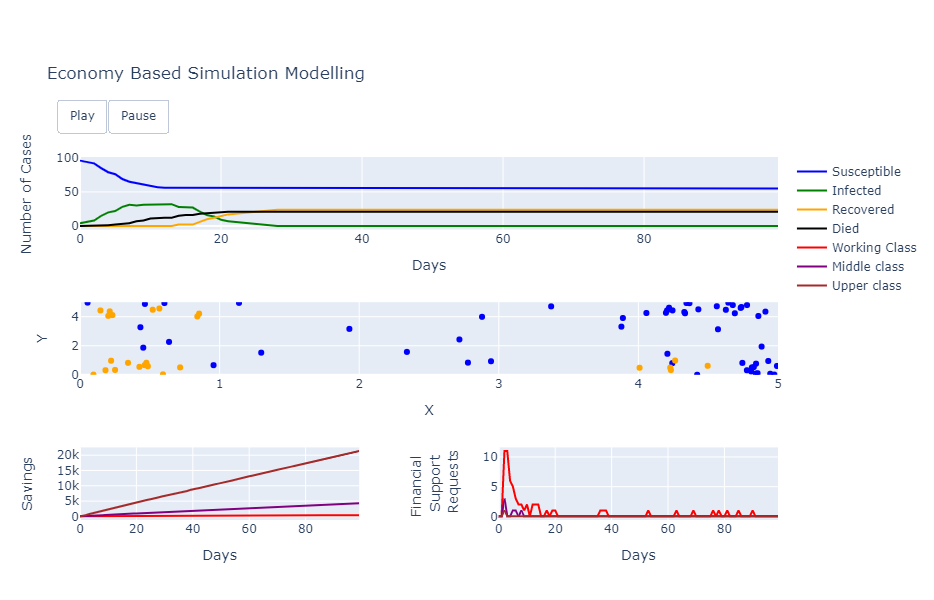

In [43]:
replay_plot(negatives, positives, survivors, deaths, df, grid_max, daily_average_savings, daily_support_requests)